In [3]:
from __future__ import annotations

import numpy as np
from abc import ABC, abstractmethod as virtual
from math import gcd
from typing import Callable
import matplotlib.pyplot as plt

from scipy.special import ndtr as Phi
from numba import jit, float64
from math import log as ln
from math import sqrt
from math import exp

import sympy as sym

import sys

In [4]:
# If someone offers A:B odds for stuff to happen, they believe there is A/(A+B) chance that stuff will happen
class SolveDoubleBet:
    """Class wrapper for the question type: Person A is offering a/b odds for some event and Person B is offering c/d odds against some event. Assume you have 100 dollars, how should you place your bets?"""
    def __init__(self, offerFor: float, offerAgainst: float, principal: float, eventForName: str = "Event A", eventAgainstName = "Event B"):
        A = offerFor
        B = offerAgainst
        P = principal
        self.P = P

        # Suppose we bet x dollars on A and P - x dollars on not A
        # If A happens, then we pay x but we collect B * (P - x)
        # so the earnings is B(P-x) - x = -(B + 1)x + BP
        # If B = (not A) happens, then we pay P - x but we collect Ax
        # so the earnings is Ax - (P - x) = (A + 1)x - P

        self.lineA = f"y = {-(B + 1)}x + {B * P}"
        self.lineB = f"y = {A + 1}x - {P}"

        # Solve for y > 0 in first one:
        # -(B + 1)x + BP > 0 means x < BP / (B + 1)
        # Solve for y > 0 in second one:
        # (A + 1)x - P > 0 means x > P/(A + 1)

        self.Arange = f"x < {B * P / (B + 1)}"
        self.Brange = f"x > {P/(A + 1)}"

        self.hasArbitrage = P / (A + 1) < B * P / (B + 1)
        self.arbitrageRange = f"{P / (A + 1)} < x < {B * P / (B + 1)}" if self.hasArbitrage else "Does not exist"

        # Find fixed income
        # -(B + 1)x + BP = (A + 1)x - P
        # BP + P = (A + B + 2)x
        # x = (BP + P)/(A + B + 2)
        self.x = (B * P + P)/(A + B + 2)
        self.fixedIncome = (A + 1) * self.x - P

        # Save the events. This swap is intentional because English is confusing. Dont worry stuff will work out
        self.Aname = eventForName
        self.Bname = eventAgainstName

    def __repr__(self):
        st = f"""\
Profit curve for {self.Aname}: {self.lineA}
Profit curve for {self.Bname}: {self.lineB}

Profit range if {self.Aname}: {self.Arange}
Profit range if {self.Bname}: {self.Brange}

Arbitrage?
"""
        if self.hasArbitrage:
            st += "Yes\n" + f"""\
Arbitrage range: {self.arbitrageRange}

Conclusion: we should bet {self.x} on {self.Aname} and {self.P - self.x} on {self.Bname}. Then we are guaranteed {self.fixedIncome} dollars earnings.

"""
        else:
            st += "No\n"

        return st

In [5]:
## Example: Midterm 1 problem 1
# Hint: If someone offers A:B odds for stuff to happen, they believe there is A/(A+B) chance that stuff will happen
# Kansas city fan offering odds with implicit probablility 5/6 => odds are 5:1
# Eagles fan offering odds with implicit probability 7/12 => odds are 7:5

# Suppose we bet 100 dollars. Suppose we are for Kansas city.
# The format is (odds for, odds agains, principal, the name of the events)
s = SolveDoubleBet(5/1, 7/5, 100, "Kansas city wins", "Eagles wins")
print(s)

Profit curve for Kansas city wins: y = -2.4x + 140.0
Profit curve for Eagles wins: y = 6.0x - 100

Profit range if Kansas city wins: x < 58.333333333333336
Profit range if Eagles wins: x > 16.666666666666668

Arbitrage?
Yes
Arbitrage range: 16.666666666666668 < x < 58.333333333333336

Conclusion: we should bet 28.57142857142857 on Kansas city wins and 71.42857142857143 on Eagles wins. Then we are guaranteed 71.42857142857142 dollars earnings.




In [7]:
class HorseRaceSolver:
    def __init__(self, prices: list[int], profit_percentage: float):
        s: float = sum(prices)
        profit = s * profit_percentage / 100
        if profit - int(profit) < 1e-6:
            profit = int(profit)

        # Set up the equation: If horse A wins, then
        # profit = horse[b] + horse[c] + ... - odds[a] * horse[a]
        # odds[a] = (horse[b] + ... - profit) / horse[a]

        self.results: list[tuple[float, float, str]] = []

        for i, v in enumerate(prices):
            num = s - v - profit
            den = v
            if isinstance(profit, int):
                g = gcd(num, den) #type: ignore
                num //= g
                den //= g
            res = f"Implied odds for horse {i}: {num}/{den}."
            odd = (num, den, res)
            self.results.append(odd)

    def __repr__(self):
        s = "\n".join(s[2] for s in self.results)
        return s

In [10]:
## Example: (Midterm 1) As the manager of a betting facility at a horse racetrack, you want a guaranteed 10% profit on all money wagered. 
# Just before a three-horse race starts, the betting windows are closed to new bets and you set the odds.
#  $64,000 was bet on Horse A, $27,000 on Horse B, and $9,000 on Horse C. Determine the odds you would set for each horse,
#   namely OA : 1, OB : 1, and OC : 1 in order to secure the desired profit, no matter which horse wins.

# What is OC ?

# Please round your numerical answer to the nearest integer.

h = HorseRaceSolver([64000, 27000, 9000], 10)
print(h)

# Hence OC = 9

Implied odds for horse 0: 13/32.
Implied odds for horse 1: 7/3.
Implied odds for horse 2: 9/1.


In [17]:
##############################################################################################################
############################################### Option #######################################################
##############################################################################################################

pi = 3.141592653589793

def phi(x):
    return exp(-x*x/2)/sqrt(2 * pi)

class Options(ABC):
    def __init__(self, exercisePrice: int):
        self.E = exercisePrice
        self._ub: int = exercisePrice + 15

    @virtual
    def __repr__(self):
        raise NotImplementedError

    @property
    @virtual
    def profit(self):
        raise NotImplementedError

    def plot(self):
        x = []
        y = []
        for i in range(self._ub * 5):
            x.append(i/5)
            y.append(self.profit(i/5))

        plt.figure()
        plt.plot(x, y)
        plt.show()

    @virtual
    def cost(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        raise NotImplementedError

    def __add__(self, other: Options) -> Options:
        return MixedPortfolio(self, other)

    def __neg__(self) -> Options:
        return ShortOption(self)

    def __sub__(self, other: Options) -> Options:
        return self + (-other)

    def __rmul__(self, lhs: int) -> Options:
        ub = self._ub
        if lhs == 0:
            return EmptyOption(ub)
        if lhs < 0:
            s = -self
            for i in range(1, -lhs):
                s = s - self
            return s
        else:
            s = self
            for i in range(1, lhs):
                s = s + self
        return s

    @virtual
    def delta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        raise NotImplementedError

    @virtual
    def vega(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        raise NotImplementedError

    @virtual
    def rho(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        raise NotImplementedError

    @virtual
    def theta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        raise NotImplementedError

    @virtual
    def gamma(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        raise NotImplementedError

class MixedPortfolio(Options):
    def __init__(self, o1: Options, o2: Options) -> None:
        self.a, self.b = o1, o2
        self._ub = max(o1._ub, o2._ub)

    @property
    def profit(self):
        return lambda x: self.a.profit(x) + self.b.profit(x)

    def __repr__(self):
        s = "Mixed portfolio"
        return s

    def cost(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        st = current_stock_price
        r = risk_free_interest
        sd = sd_continuous_annual_return
        t = time_to_maturity
        return self.a.cost(st, r, sd, t) + self.b.cost(st, r, sd, t)

    def delta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        st = current_stock_price
        r = risk_free_interest
        sd = sd_continuous_annual_return
        t = time_to_maturity
        return self.a.delta(st, r, sd, t) + self.b.delta(st, r, sd, t)

    def vega(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        st = current_stock_price
        r = risk_free_interest
        sd = sd_continuous_annual_return
        t = time_to_maturity
        return self.a.vega(st, r, sd, t) + self.b.vega(st, r, sd, t)

    def theta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        st = current_stock_price
        r = risk_free_interest
        sd = sd_continuous_annual_return
        t = time_to_maturity
        return self.a.theta(st, r, sd, t) + self.b.theta(st, r, sd, t)

    def rho(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        st = current_stock_price
        r = risk_free_interest
        sd = sd_continuous_annual_return
        t = time_to_maturity
        return self.a.rho(st, r, sd, t) + self.b.rho(st, r, sd, t)

    def gamma(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        st = current_stock_price
        r = risk_free_interest
        sd = sd_continuous_annual_return
        t = time_to_maturity
        return self.a.gamma(st, r, sd, t) + self.b.gamma(st, r, sd, t)

class ShortOption(Options):
    def __init__(self, o: Options):
        self.o = o
        self._ub = o._ub

    @property
    def profit(self):
        return lambda x: -self.o.profit(x)

    def __repr__(self):
        return f"- {self.o}"

    def cost(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return -self.o.cost(current_stock_price, risk_free_interest, sd_continuous_annual_return, time_to_maturity)

    def delta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return -self.o.delta(current_stock_price, risk_free_interest, sd_continuous_annual_return, time_to_maturity)

    def vega(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return -self.o.vega(current_stock_price, risk_free_interest, sd_continuous_annual_return, time_to_maturity)

    def rho(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return -self.o.rho(current_stock_price, risk_free_interest, sd_continuous_annual_return, time_to_maturity)

    def theta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return -self.o.theta(current_stock_price, risk_free_interest, sd_continuous_annual_return, time_to_maturity)

    def gamma(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return -self.o.gamma(current_stock_price, risk_free_interest, sd_continuous_annual_return, time_to_maturity)

class EmptyOption(Options):
    def __init__(self, ub):
        self._ub = ub

    @property
    def profit(self):
        return lambda _: 0

    def __repr__(self):
        return ""

    def cost(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return 0

    def delta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return 0

    def vega(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return 0

    def rho(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return 0

    def theta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return 0

    def gamma(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        return 0

class Call(Options):
    @property
    def profit(self):
        return lambda x: max(0, x - self.E)

    def __repr__(self):
        return f"C(E = {self.E})"

    def cost(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        """The black scholes cost of a Call option, calculated using the formula in p31 lecture 12
        Enter risk free interest rate and standard deviation using percecntage"""
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        cost = S * Phi(d1) - K * np.exp(-r*T)* Phi(d2)
        return cost

    def delta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        delta = Phi(d1)
        return delta

    def vega(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))

        vega = S * phi(d1) * sqrt(T)
        return vega

    def rho(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        rho = K * T * exp(-r * T) * Phi(d2)
        return rho

    def theta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        theta = - (S * phi(d1) * sigma) / (2 * sqrt(T)) - r * K * exp(-r * T) * Phi(d2)
        return theta

    def gamma(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        """The black scholes cost of a Call option, calculated using the formula in p31 lecture 12
        Enter risk free interest rate and standard deviation using percecntage"""
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))

        gamma = phi(d1)/(S * sigma * sqrt(T))
        return gamma

class Put(Options):
    @property
    def profit(self):
        return lambda x: max(0, self.E - x)

    def __repr__(self):
        return f"P(E = {self.E})"

    def cost(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        """The black scholes cost of a Put option, calculated using the formula in p31 lecture 12
        Enter risk free interest rate and standard deviation using percecntage"""
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        cost = K * exp(-r*T)* Phi(-d2) - S * Phi(-d1)
        return cost

    def delta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        """The black scholes cost of a Put option, calculated using the formula in p31 lecture 12
        Enter risk free interest rate and standard deviation using percecntage"""
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))

        delta = Phi(d1) - 1
        return delta

    def vega(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        """The black scholes cost of a Put option, calculated using the formula in p31 lecture 12
        Enter risk free interest rate and standard deviation using percecntage"""
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))

        vega = S * phi(d1) * sqrt(T)
        return vega

    def rho(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        """The black scholes cost of a Put option, calculated using the formula in p31 lecture 12
        Enter risk free interest rate and standard deviation using percecntage"""
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        rho = -K * T * exp(-r * T) * Phi(-d2)
        return rho

    def theta(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        """The black scholes cost of a Put option, calculated using the formula in p31 lecture 12
        Enter risk free interest rate and standard deviation using percecntage"""
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        theta = - (S * phi(d1) * sigma) / (2 * sqrt(T)) + r * K * exp(-r * T) * Phi(-d2)
        return theta

    def gamma(self, current_stock_price: float, risk_free_interest: float, sd_continuous_annual_return: float, time_to_maturity: float):
        """The black scholes cost of a Put option, calculated using the formula in p31 lecture 12
        Enter risk free interest rate and standard deviation using percecntage"""
        S = current_stock_price
        r = risk_free_interest/100
        sigma = sd_continuous_annual_return/100
        T = time_to_maturity
        K = self.E

        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))

        gamma = phi(d1)/(S * sigma * sqrt(T))
        return gamma

def fst1(st, mode, mu, sd, t):
    mu1 = ln(st) + t * (mu - 1/2 * sd * sd)
    s1 = sqrt(sd * sd * t)
    r = 1/mode / s1 / sqrt(2 * pi) * exp(-1/2 * ((ln(mode) - mu1)/s1) ** 2)
    return r

def fst2(st, mu, sd, t):
    return 1/(np.sqrt(2*pi) * st * sd * np.sqrt(t)) * np.exp((sd * sd - mu) * t)

def mode_of_stock_price(stock_price, mean_return, sd_return, time_to_maturity):
    S = stock_price
    mu = mean_return/100
    sd = sd_return/100
    t = time_to_maturity

    mode = S * exp((mu - 3/2*sd*sd) * t)
    print(f"Mode: {mode}")

    rr = fst1(S, mode, mu, sd, t)
    print(f"f(S(t)) = {rr}")

    rr2 = fst2(S, mu, sd, t)
    print(f"f(S(t)) = {rr2}")

    return mode

## Use binary search to reverse engineer answer
class FindAnswer:
    """Given a function f and a target value y, solve for x in y = f(x) for start < x < end"""
    __slots__ = ("start", "end", "target", "f")

    def __init__(self, start: float, end: float, targetValue: float, f: Callable[[float], float]):
        if start > end:
            start, end = end, start
        self.start = start
        self.end = end
        self.target = targetValue
        self.f = f

    @property
    def diff(self) -> float:
        return abs(self.end - self.start)

    @property
    def mid(self) -> float:
        return (self.start + self.end) / 2

    def isBetween(self):
        """Returns true if target is between value 1 and value 2"""
        return self.f(self.start) <= self.target <= self.f(self.end) or self.f(self.end) <= self.target <= self.f(self.start)


    def __call__(self, accuracy: float = 0.0000001, partitions: int = 10) -> Generator[float, None, None]:
        ## Use the marching line approach to narrow it down first
        ## Plus recursion to narrow it down
        ## Only works if the function is not too crazy

        # Base case
        if self.diff < accuracy and self.isBetween():
            yield self.mid
            return

        ## Recursive
        increment = self.diff / partitions

        # Calculates the value
        values = [self.start + increment * i for i in range(partitions + 1)]

        # Recursively yield the values
        for i in range(partitions):
            ## By the intermediate value theorem
            subrange = FindAnswer(values[i], values[i+1], targetValue = self.target, f = self.f)
            if subrange.isBetween():
                for v in subrange(accuracy, partitions):
                    yield v

        return

    @property
    def answer(self) -> float:
        return next(self())

def implied_vol_call(cost, risk_free, strike_price, stock_price, time_maturity):
    def f(s):
        return Call(strike_price).cost(stock_price, risk_free, s, time_maturity)
    return FindAnswer(0.00001, 300, cost, f).answer

def implied_vol_put(cost, risk_free, strike_price, stock_price, time_maturity):
    def f(s):
        return Put(strike_price).cost(stock_price, risk_free, s, time_maturity)
    return FindAnswer(0.00001, 300, cost, f).answer

Profit curve for call option with 100 dollars strike price


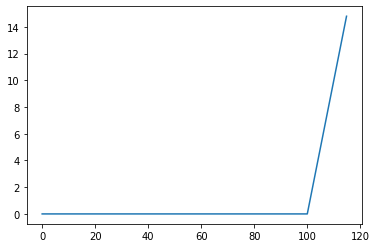

Profit curve for put option with 100 dollars strike price


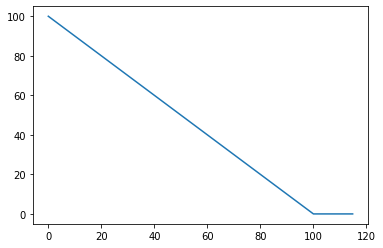

Cost of call: 12.82158139269142
Delta of call: 0.5857659364695248
Vega of call: 38.96872613869686
Rho of call: 45.75501225426106
Gamma of call: 0.01298957537956562
Cost of put: 10.841448723366952
Delta of put: -0.4142340635304752
Vega of put: 38.96872613869686
Rho of put: -52.26485507641447
Gamma of put: 0.01298957537956562


In [15]:
# Ok this will be a long example but hang on tight
# I hope by the end of these example I can convince you why using classes to write options is preferrable
# If not, just use option creator :)

# Here is how you create an option with exercise price 100
c = Call(100)

# Here is how you create a put option with exercise price 100
p = Put(100)

# First, we can plot out its profit curve like follows: 
print("Profit curve for call option with 100 dollars strike price")
c.plot()

print("Profit curve for put option with 100 dollars strike price")
p.plot()

# Now assume the option is at the money, the risk free rate is 2%, and the stock price volatility is 30%, time to maturity is 1 years
# According to black scholes option pricing theory, the price of the call is:
call_cost = c.cost(100, 2, 30, 1)

# According to black scholes option pricing theory, the price of the put is:
put_cost = p.cost(100, 2, 30, 1)

# We get all the greeks similarly
call_delta = c.delta(100, 2, 30, 1)
call_gamma = c.gamma(100, 2, 30, 1)
call_vega = c.vega(100, 2, 30, 1)
call_theta = c.theta(100, 2, 30, 1)
call_rho = c.rho(100, 2, 30, 1)

put_delta = p.delta(100, 2, 30, 1)
put_gamma = p.gamma(100, 2, 30, 1)
put_vega = p.vega(100, 2, 30, 1)
put_theta = p.theta(100, 2, 30, 1)
put_rho = p.rho(100, 2, 30, 1)

# Feel free to try printing out these values to make sure they are correct

print(f"Cost of call: {call_cost}")
print(f"Delta of call: {call_delta}")
print(f"Vega of call: {call_vega}")
print(f"Rho of call: {call_rho}")
print(f"Gamma of call: {call_gamma}")

print(f"Cost of put: {put_cost}")
print(f"Delta of put: {put_delta}")
print(f"Vega of put: {put_vega}")
print(f"Rho of put: {put_rho}")
print(f"Gamma of put: {put_gamma}")

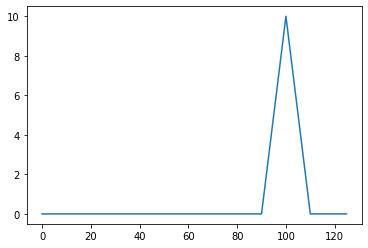

In [18]:
# Here is where the object-oriented way of doing things shines
# We have something called 'operator overloading', which means you can add and subtract options like normal :D
# We can thus see the profit curves for arbitrary portfolios
# A 'negative' option  is the same as shorting an option

# Here is the profit curve for a "Long butterfly": 
# Long 1 call with a strike price of 90
# Short 2 calls with a strike price of 100
# Long 1 call with a strike price of 110

portfolio = Call(90) - 2 * Call(100) + Call(110)
portfolio.plot()

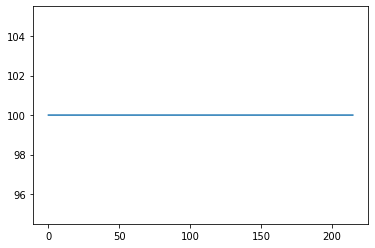

In [20]:
# Example: (midterm) Assume the risk-free rate is 0%. How much does the following portfolio worth?
# • Long 1 call option with a strike price of of $100
# • Short 1 put option with a strike price of of $100
# • Short 1 call option with a strike price of of $200
# • Long 1 put option with a strike price of of $200

# Honestly I had no idea how to even begin with this question. I tried plotting out the profit curve.

portfolio = Call(100) - Put(100) - Call(200) + Put(200)
portfolio.plot()

# Now we see the profit of this position is always 100 dollars. By arbitrage magic
# the price of the portfolio at expiration must also be 100 dollars.